In [1]:
from scipy.sparse import coo_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [2]:
import pandas as pd
import nltk
import sklearn as sk
import gensim.models
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
sns.set()

clean = pd.read_csv("/Users/aditya/Google Drive (as11919@nyu.edu)/Syncing with Mac/NYU Research Analysis/Motivation Lab/CleanData(v. analysis).csv")

colname = ['id', 'condition', 'wish', 'outcome', 'outcome2', 'useful', 'mins', 'other', 'reuse', 'clarity', 'benefit', 'interest', 'learn']
clean = clean.iloc[:256,:13]
clean.columns= colname
clean.fillna("", inplace=True)
clean.head()

,id,condition,wish,outcome,outcome2,useful,mins,other,reuse,clarity,benefit,interest,learn
0,558af269fdf99b7dfef4d7bd,MC,do a Bible study,finish Bible study and feel fulfilled,I'll do the Bible study I've been meaning to d...,7.0,1.0,7.0,7.0,7.0,7.0,7.0,7.0
1,55b1add5fdf99b6731f04c5a,MC,I want to clean my house,I will get everything tidy,I will feel better in a nice clean house,1.0,1.0,2.0,1.0,3.0,1.0,2.0,2.0
2,5626a6cfddff3c0011bcd3d8,I,Eat healthy and exercise,I burn more calories than I eat,I feel accomplished and good about mysefl,3.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
3,56a5da6181a8ca000d3e7f40,MC,Spend quality time with my cat,My cat appears happy,"When my cat is happy, he is laying next to me ...",4.0,1.0,4.0,3.0,2.0,3.0,5.0,4.0
4,56df2ea2452e1300056bc7df,MC,Go out to eat,Care Free,"Happy, no problems",3.0,1.0,4.0,4.0,3.0,3.0,4.0,3.0


In [3]:
clean['all'] = clean.wish + " " + clean.outcome + " " + clean.outcome2
clean.drop(columns = ['wish', 'outcome', 'outcome2'], inplace=True)

# clean['all'] = clean['all'].apply(remove_stop)
# model = gensim.models.Word2Vec(clean['all'], min_count = 2)
# model.most_similar('happy')

# clean = pd.get_dummies(clean, columns = ['useful','mins','other','reuse', 'clarity', 'benefit', 'interest', 'learn'])
clean.head()

,id,condition,useful,mins,other,reuse,clarity,benefit,interest,learn,all
0,558af269fdf99b7dfef4d7bd,MC,7.0,1.0,7.0,7.0,7.0,7.0,7.0,7.0,do a Bible study finish Bible study and feel f...
1,55b1add5fdf99b6731f04c5a,MC,1.0,1.0,2.0,1.0,3.0,1.0,2.0,2.0,I want to clean my house I will get everything...
2,5626a6cfddff3c0011bcd3d8,I,3.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Eat healthy and exercise I burn more calories ...
3,56a5da6181a8ca000d3e7f40,MC,4.0,1.0,4.0,3.0,2.0,3.0,5.0,4.0,Spend quality time with my cat My cat appears ...
4,56df2ea2452e1300056bc7df,MC,3.0,1.0,4.0,4.0,3.0,3.0,4.0,3.0,"Go out to eat Care Free Happy, no problems"


In [4]:
# clean['all'] = clean['all'].apply(lambda x:' '.join(x))

useful


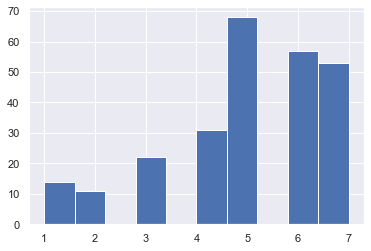

mins


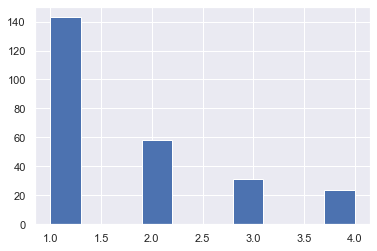

other


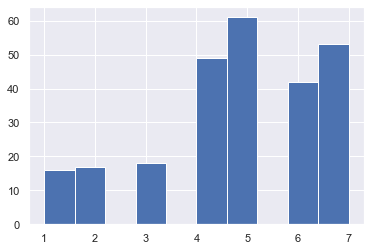

reuse


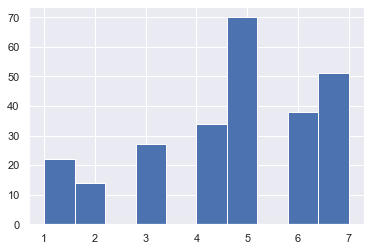

clarity


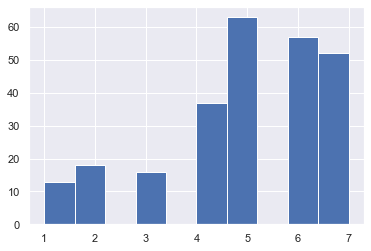

benefit


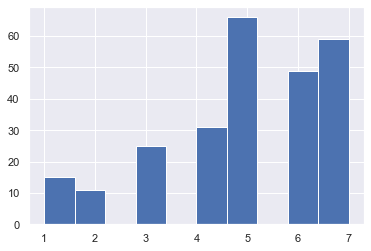

interest


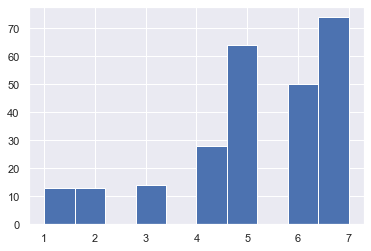

learn


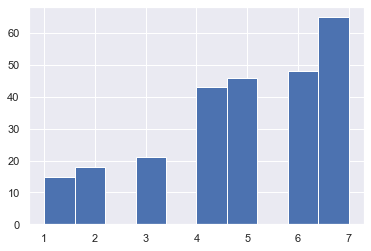

In [5]:
for each_col in clean.loc[:,'useful':'learn']:
    print(each_col)
    plt.hist(clean[each_col])
    plt.show()

In [6]:
history_scores = defaultdict(dict)

In [7]:
class predictor:
    def __init__(self, df, Xcolname, kind='l2', solver='lbfgs'):
        self.stop_words = stopwords.words("english")
        df['num_stop'] = df[Xcolname].apply(self.count_stop)
        self.df = df
        self.kind=kind
        self.solver=solver
        self.vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words={'english'})
        X = self.vectorizer.fit_transform(df[Xcolname])
        self.X = hstack((X,np.array(df['num_stop'])[:,None]))
    
    def count_stop(self, entry):
        new = entry.lower()
        new = nltk.word_tokenize(new)
        num_stop = sum([1 for x in new if x in self.stop_words])
        return(num_stop)

    def set_Y(self, Ycolname):
        self.y = self.df[Ycolname]
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.10, random_state=0)
        
    def train(self, Ycolname):
        self.set_Y(Ycolname)
        self.model = LogisticRegression(max_iter=1000, penalty=self.kind, solver=self.solver, class_weight='balanced').fit(self.x_train,self.y_train)
        print(cross_validate(self.model, self.x_train, self.y_train, return_train_score=True, cv=3))

    def test(self):
        score = self.model.score(self.x_test, self.y_test)
        print(score)
        return(score)
    
    def predict(self, x):
        count = self.count_stop(x[0])
        x = self.vectorizer.transform(x)
        x = hstack((x,np.array([count])[:,None]))
        return(self.model.predict_proba(x), "The pred is = ", self.model.predict(x))

In [8]:
def variation(kind, solver):
    mypredictor = predictor(clean, 'all', kind, solver)
    history_scores[f'{mypredictor.solver}'][f'{mypredictor.kind}'] = {}
    for each_col in clean.loc[:,'useful':'learn']:
        print(each_col)
        mypredictor.train(each_col)
        history_scores[f'{mypredictor.solver}'][f'{mypredictor.kind}'][f'{each_col}'] = mypredictor.test()

In [9]:
# variation('l2', 'liblinear')

useful
{'fit_time': array([0.00562096, 0.00566912, 0.00567198]), 'score_time': array([0.00073695, 0.00073195, 0.0006988 ]), 'test_score': array([0.23376623, 0.19480519, 0.31578947]), 'train_score': array([0.92810458, 0.94771242, 0.88961039])}
0.2692307692307692
mins
{'fit_time': array([0.00429106, 0.00343299, 0.00349689]), 'score_time': array([0.00065684, 0.00068831, 0.00053   ]), 'test_score': array([0.54545455, 0.54545455, 0.47368421]), 'train_score': array([0.91503268, 0.94771242, 0.8961039 ])}
0.5769230769230769
other
{'fit_time': array([0.00556231, 0.00557089, 0.00536704]), 'score_time': array([0.00064182, 0.00064397, 0.00059485]), 'test_score': array([0.23376623, 0.28571429, 0.26315789]), 'train_score': array([0.92810458, 0.96078431, 0.92857143])}
0.3076923076923077
reuse
{'fit_time': array([0.00556111, 0.00550079, 0.00532913]), 'score_time': array([0.00063992, 0.00065422, 0.00059295]), 'test_score': array([0.20779221, 0.18181818, 0.25      ]), 'train_score': array([0.92810458, 0

In [10]:
# variation('l1', 'liblinear')

useful
{'fit_time': array([0.00560594, 0.00583386, 0.00639987]), 'score_time': array([0.00065398, 0.00066304, 0.00079203]), 'test_score': array([0.20779221, 0.12987013, 0.23684211]), 'train_score': array([0.32026144, 0.2745098 , 0.27272727])}
0.2692307692307692
mins
{'fit_time': array([0.00391603, 0.0040319 , 0.00381804]), 'score_time': array([0.00056505, 0.0005703 , 0.00061965]), 'test_score': array([0.54545455, 0.54545455, 0.53947368]), 'train_score': array([0.5751634 , 0.58169935, 0.55194805])}
0.6153846153846154
other
{'fit_time': array([0.00559902, 0.00594473, 0.00534081]), 'score_time': array([0.00063396, 0.00066209, 0.00062013]), 'test_score': array([0.23376623, 0.22077922, 0.17105263]), 'train_score': array([0.32026144, 0.30718954, 0.27272727])}
0.23076923076923078
reuse
{'fit_time': array([0.00572586, 0.00567079, 0.00572586]), 'score_time': array([0.00062013, 0.00065804, 0.00065899]), 'test_score': array([0.20779221, 0.15584416, 0.21052632]), 'train_score': array([0.24836601, 

In [11]:
# variation('l2', 'lbfgs')

useful
{'fit_time': array([0.50132298, 0.44543934, 0.43080187]), 'score_time': array([0.00483894, 0.00108171, 0.00092697]), 'test_score': array([0.20779221, 0.16883117, 0.30263158]), 'train_score': array([0.90849673, 0.92810458, 0.8961039 ])}
0.23076923076923078
mins
{'fit_time': array([0.26561403, 0.33484793, 0.29441404]), 'score_time': array([0.00626016, 0.00107598, 0.00061417]), 'test_score': array([0.44155844, 0.51948052, 0.31578947]), 'train_score': array([0.94117647, 0.96078431, 0.94155844])}
0.34615384615384615
other
{'fit_time': array([0.47692609, 0.5583179 , 0.30522513]), 'score_time': array([0.00067306, 0.00215101, 0.00063491]), 'test_score': array([0.23376623, 0.25974026, 0.23684211]), 'train_score': array([0.94117647, 0.95424837, 0.91558442])}
0.38461538461538464
reuse
{'fit_time': array([0.19777799, 0.63495612, 0.20408702]), 'score_time': array([0.00081205, 0.00269604, 0.00069404]), 'test_score': array([0.22077922, 0.15584416, 0.26315789]), 'train_score': array([0.92156863

In [12]:
# variation('l2', 'newton-cg')

useful
{'fit_time': array([0.15278387, 0.07142305, 0.07770967]), 'score_time': array([0.00123   , 0.00258279, 0.00056028]), 'test_score': array([0.19480519, 0.16883117, 0.30263158]), 'train_score': array([0.90849673, 0.92810458, 0.8961039 ])}
0.23076923076923078
mins
{'fit_time': array([0.03699207, 0.05515122, 0.03426719]), 'score_time': array([0.00062418, 0.00059605, 0.0005331 ]), 'test_score': array([0.44155844, 0.51948052, 0.31578947]), 'train_score': array([0.94117647, 0.96078431, 0.94155844])}
0.34615384615384615
other
{'fit_time': array([0.12592506, 0.08518314, 0.08756995]), 'score_time': array([0.0006249 , 0.00055385, 0.00062895]), 'test_score': array([0.23376623, 0.27272727, 0.23684211]), 'train_score': array([0.94117647, 0.95424837, 0.91558442])}
0.38461538461538464
reuse
{'fit_time': array([0.05378485, 0.05995417, 0.10056186]), 'score_time': array([0.00071597, 0.00115299, 0.00731111]), 'test_score': array([0.22077922, 0.15584416, 0.26315789]), 'train_score': array([0.92156863

In [13]:
history_scores

defaultdict(dict,
            {'liblinear': {'l2': {'useful': 0.2692307692307692,
               'mins': 0.5769230769230769,
               'other': 0.3076923076923077,
               'reuse': 0.2692307692307692,
               'clarity': 0.19230769230769232,
               'benefit': 0.15384615384615385,
               'interest': 0.23076923076923078,
               'learn': 0.11538461538461539},
              'l1': {'useful': 0.2692307692307692,
               'mins': 0.6153846153846154,
               'other': 0.23076923076923078,
               'reuse': 0.23076923076923078,
               'clarity': 0.3076923076923077,
               'benefit': 0.19230769230769232,
               'interest': 0.23076923076923078,
               'learn': 0.2692307692307692}},
             'lbfgs': {'l2': {'useful': 0.23076923076923078,
               'mins': 0.34615384615384615,
               'other': 0.38461538461538464,
               'reuse': 0.11538461538461539,
               'clarity': 0.15384

In [14]:
coders = pd.read_csv('/Users/aditya/Google Drive (as11919@nyu.edu)/Syncing with Mac/NYU Research Analysis/Motivation Lab/MCII coding replication - coding file(v. analysis).csv')
colname = ['id', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 's1', 's2', 's3', 's4', 's5', 's6']
coders = coders.iloc[:256,:13]
coders.columns= colname
coders.fillna(1, inplace=True)
coders.head()

,id,d1,d2,d3,d4,d5,d6,s1,s2,s3,s4,s5,s6
0,558af269fdf99b7dfef4d7bd,2.0,2.0,5.0,2.0,2.0,5.0,2.0,5.0,5.0,2.0,5.0,5.0
1,55b1add5fdf99b6731f04c5a,5.0,5.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,4.0,3.0,5.0
2,5626a6cfddff3c0011bcd3d8,2.0,5.0,5.0,2.0,5.0,5.0,3.0,5.0,4.0,3.0,5.0,4.0
3,56a5da6181a8ca000d3e7f40,2.0,5.0,5.0,2.0,5.0,5.0,3.0,3.0,4.0,3.0,3.0,4.0
4,56df2ea2452e1300056bc7df,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0


In [15]:
coders['d'] = round(coders.loc[:,'d1':'d6'].mean(axis=1))
coders['s'] = round(coders.loc[:,'s1':'s6'].mean(axis=1))
# coders = coders[['id','d','s']]

In [16]:
clean = pd.concat([clean, coders], join='outer', axis=1)

In [18]:
mypredictor_coding = predictor(clean, 'all')
mypredictor_coding.train('s')
mypredictor_coding.test()

{'fit_time': array([0.33329797, 0.51799893, 0.27703595]), 'score_time': array([0.00057507, 0.00056791, 0.00064588]), 'test_score': array([0.63636364, 0.57142857, 0.53947368]), 'train_score': array([0.77777778, 0.79738562, 0.79220779])}
0.5769230769230769


0.5769230769230769

In [19]:
mypredictor_coding.predict(["Get extra hours at work so I can be able to pay for things my family needs I would be able to take care of my family and what they need or want If I was able to fulfill this goal, I would have extra hours to able to bring more money home to my family and take care of the little things that we need and want. We could be able to go on vacation and do whatever extra stuff that we want."])

(array([[8.04174837e-20, 3.12112536e-06, 8.29003558e-03, 7.20391459e-02,
         9.19667697e-01]]), 'The pred is = ', array([5.]))

In [20]:
pd.DataFrame(mypredictor_coding.model.coef_[0][:-1], 
             mypredictor_coding.vectorizer.get_feature_names(), 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
nice,1.032567
best outcome,0.895995
outcome,0.840696
best,0.776535
very,0.727568
...,...
satisfied,-0.263350
excited,-0.269013
very excited,-0.299798
clean,-0.347384


In [21]:
#effect of imbalance? 
#interpretting coeff? 
#useful exercise? What can be done? 
#how better approximate coders? 

In [44]:
coder1_specific_d = clean[['all','d1','d2','d3']][:128]
coder1_specific_d['d'] = round(coder1_specific_d[coder1_specific_d.columns[-3:]].mean(axis=1))
coder2_specific_d = clean[['all','d1','d2','d3']][128:]
coder2_specific_d['d'] = round(coder2_specific_d[coder2_specific_d.columns[-3:]].mean(axis=1))
coder3_specific_d = clean[['all','d4','d5','d6']][:128]
coder3_specific_d['d'] = round(coder3_specific_d[coder3_specific_d.columns[-3:]].mean(axis=1))
coder4_specific_d = clean[['all','d4','d5','d6']][128:]
coder4_specific_d['d'] = round(coder4_specific_d[coder4_specific_d.columns[-3:]].mean(axis=1))

In [46]:
coder1_specific_d_predictor = predictor(coder1_specific_d, 'all')
coder1_specific_d_predictor.train('d')
coder1_specific_d_predictor.test()

{'fit_time': array([0.19108129, 0.29073691, 0.30254698]), 'score_time': array([0.00072765, 0.00057507, 0.00055099]), 'test_score': array([0.48717949, 0.5       , 0.5       ]), 'train_score': array([0.85526316, 0.81818182, 0.93506494])}
0.23076923076923078


0.23076923076923078